In [17]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from pathlib import Path
from MITRotor import IEA15MW

In [18]:
rotor = IEA15MW()

nElements = 32
nSections = 191

In [19]:
def extract_columns(file_list):
    data_dict = {}
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            
            # Use the filename without the path and extension as the dictionary key
            key = Path(file).parent.name
            data_dict[key] = data
    
    return data_dict

In [20]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/15MW/gad_sweep/*/input_sounding")

data = extract_columns(file_list)

t = np.linspace(0,2*np.pi,nSections)
r = np.linspace(0,1,nElements)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * rotor.R + 378

In [21]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [22]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']

wrfles_bem = []
for count, name in enumerate(casenames):
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/15MW/gad_sweep/'+casenames[count]+'_new.npz')))

/tmp/ipykernel_3755411/1146737709.py:47: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)
/tmp/ipykernel_3755411/1146737709.py:49: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind_annular[:,count], ct_annular[:,count], cmap='viridis', s=30, edgecolor='none',color='#176d2e',alpha=0.45,zorder=1)
/tmp/ipykernel_3755411/1146737709.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(ind_annular[:,count], ct_annular[:,count], cmap='viridis', s=110, edgecolor='none',color='#176d2e',zorder=3,alpha=0.10)


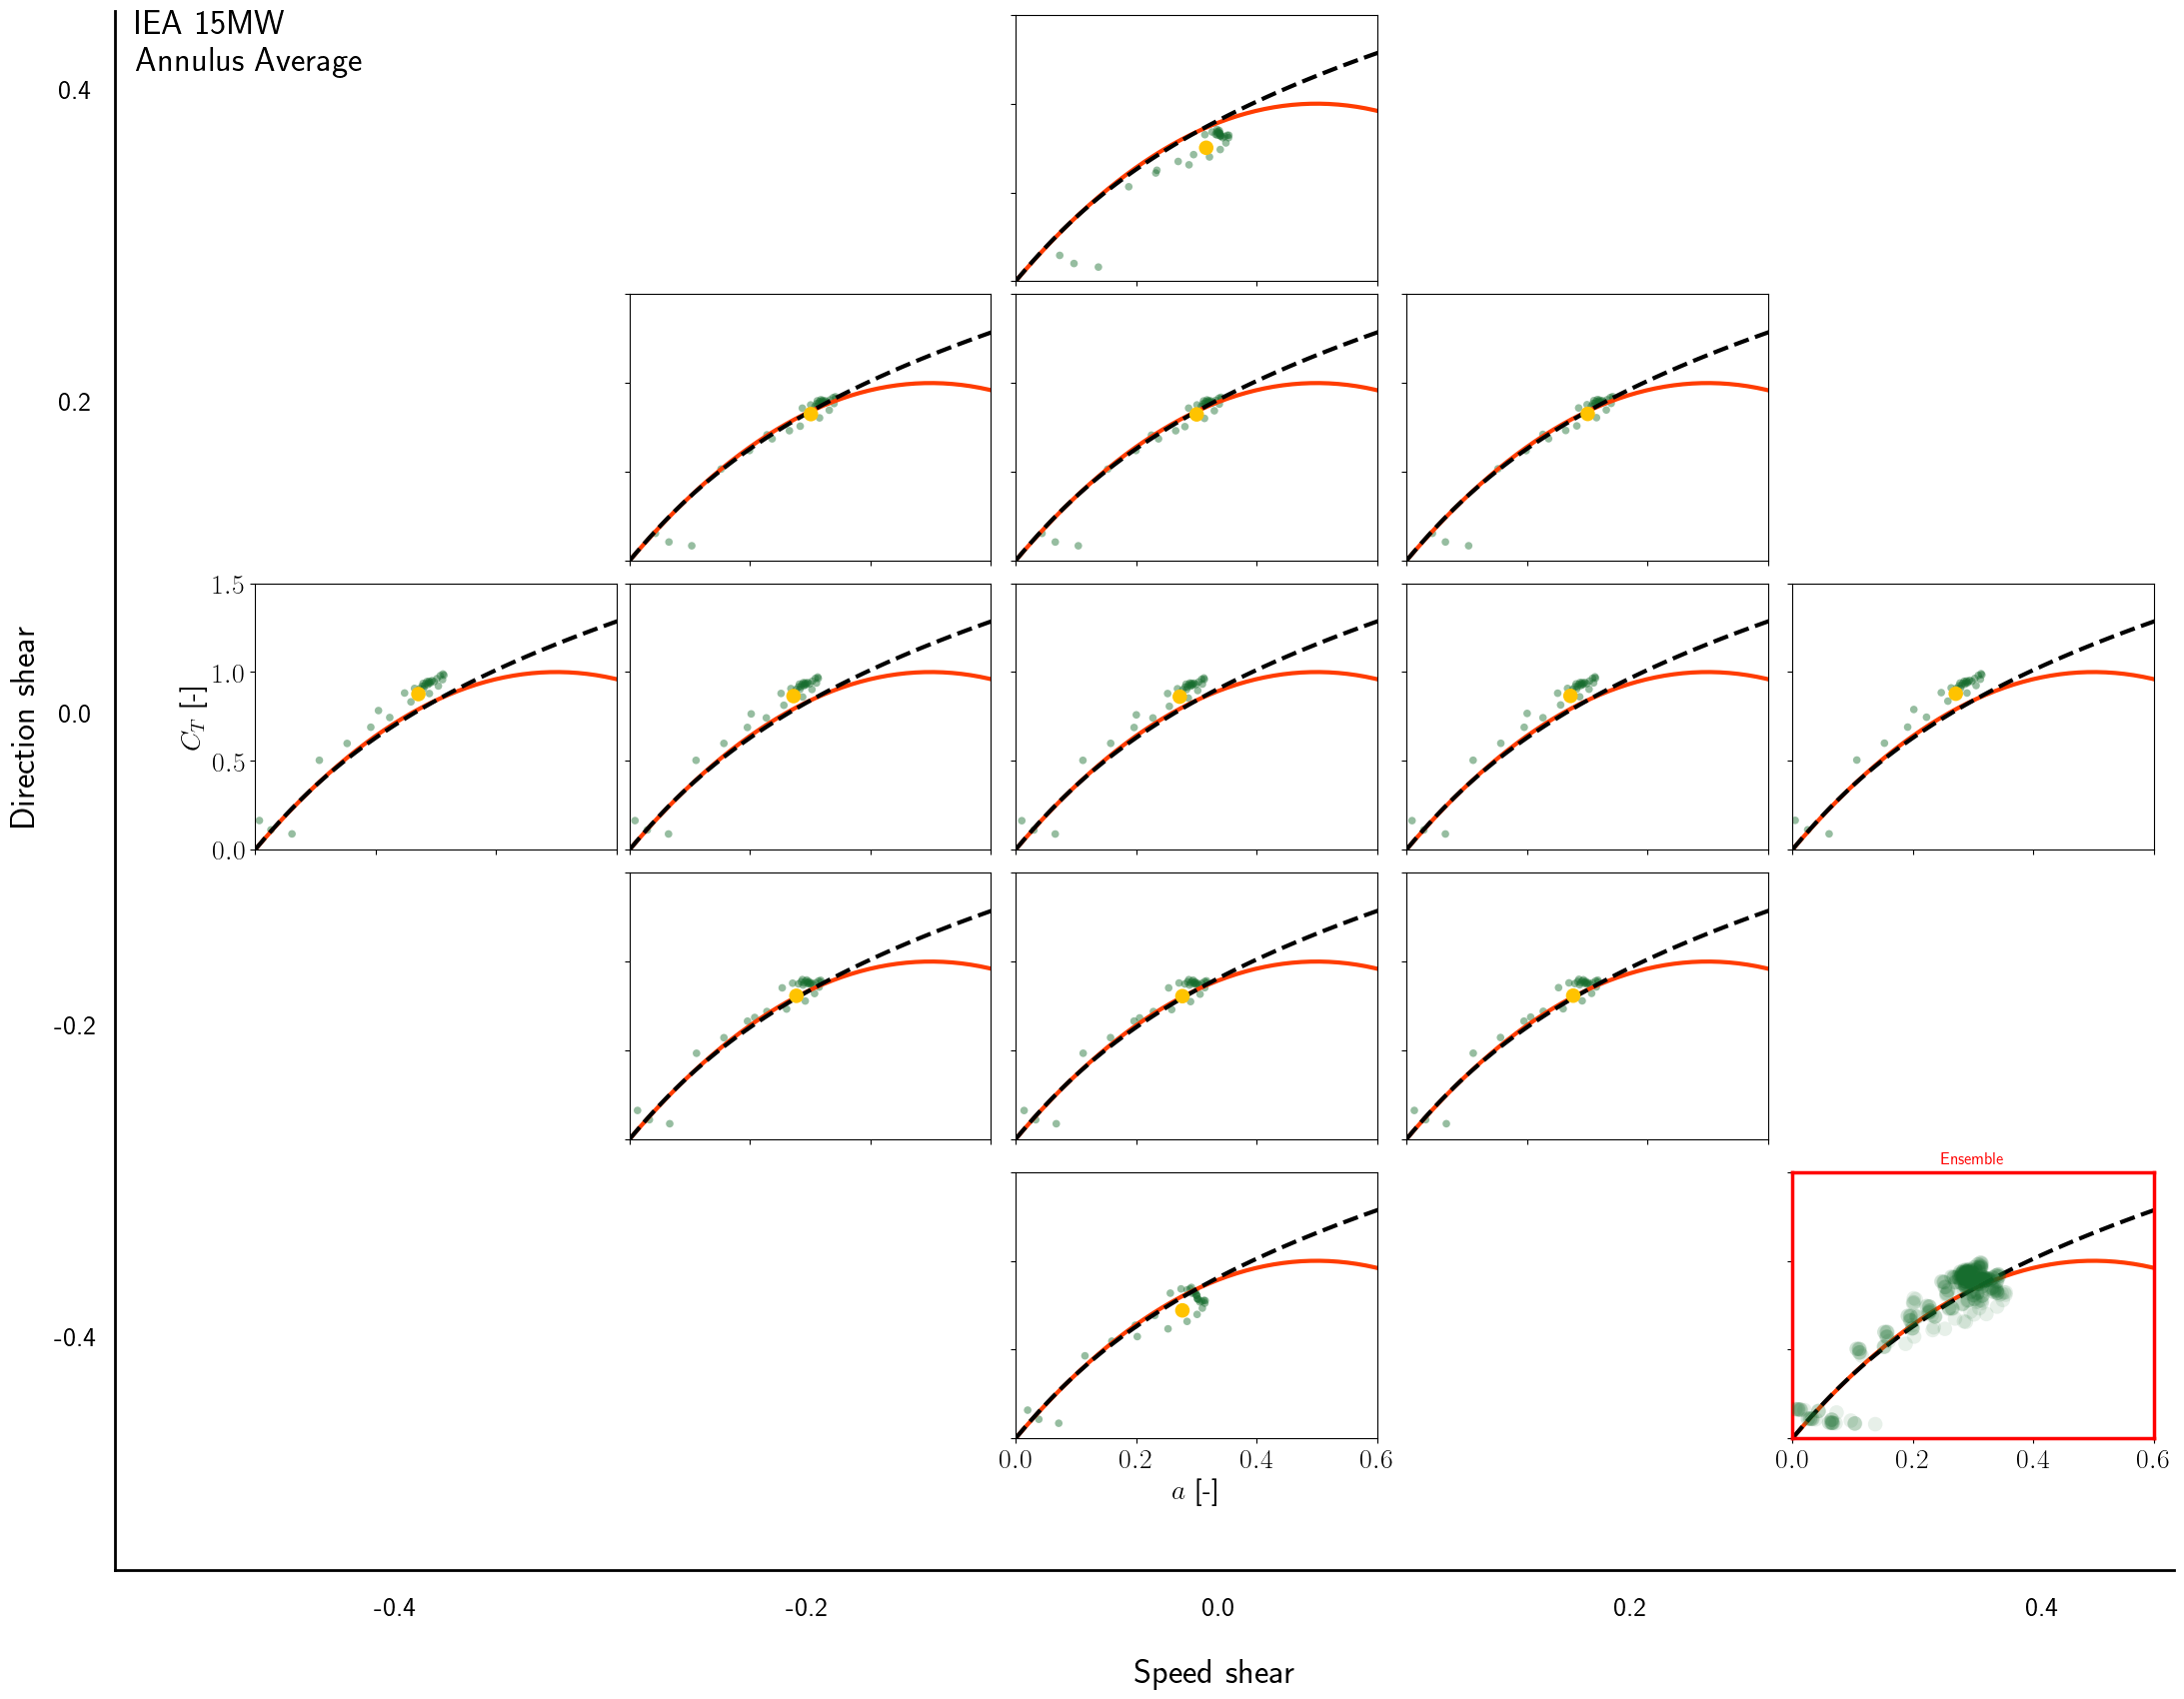

In [23]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

ind_annular = np.zeros((nElements, len(xs)))
ct_annular  = np.zeros((nElements, len(xs)))

for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    # Compute induction
    ind = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T

    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    sigma = rotor.solidity_func(r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / ((u_inf**2 + v_inf**2)**(1/2)).T

    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    ct = sigma * W**2 * Cax

    ct_annular[:,count]  = 1/(2 * np.pi) * np.trapezoid(ct, np.linspace(0, 2*np.pi, nSections))
    ind_annular[:,count] = 1/(2 * np.pi) * np.trapezoid(ind, np.linspace(0, 2*np.pi, nSections))

    ct_rotor = 2 * np.trapezoid(ct_annular[:,count] * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    ind_rotor = 2 * np.trapezoid(ind_annular[:,count] * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)

    mesh = ax[xs[count],ys[count]].scatter(ind_annular[:,count], ct_annular[:,count], cmap='viridis', s=30, edgecolor='none',color='#176d2e',alpha=0.45,zorder=1)

    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3)

    ct_mad = np.linspace(0,1.5,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3)

    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    ax[4,4].scatter(ind_annular[:,count], ct_annular[:,count], cmap='viridis', s=110, edgecolor='none',color='#176d2e',zorder=3,alpha=0.10)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)

# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)

line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)
fig.text(-0.02,0.985, 'IEA 15MW', ha='left', fontsize=25,rotation=0)
fig.text(-0.02,0.96, 'Annulus Average', ha='left', fontsize=25,rotation=0)

plt.savefig(f"./figs/wrf_15MW_annular.png", bbox_inches="tight", dpi=600)
plt.show()

In [24]:
# Define the specific equation (e.g., linear: y = a * x + b)
def madsen_func(CT, a, b, c):

    # k1 = 0.0883
    # k2 = 0.0586
    # k3 = 0.2460

    return a * CT**3 + b * CT**2 + c * CT

In [25]:
# V4

v4 = [0,12]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind_annular[:,v4].flatten()
ct_mom = ct_annular[:,v4].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit_v4, b_fit_v4, c_fit_v4 = params
print(f"Fitted parameters: a = {a_fit_v4:.3f}, b = {b_fit_v4:.3f}, c = {c_fit_v4:.3f},")
np.save("./annulus_coefficients/v4_15MW_annulus_coefficients.npy", [a_fit_v4,b_fit_v4,c_fit_v4])

# Generate fitted values
x_fit_v4 = np.linspace(0, 0.6, 100)
y_fit_v4 = madsen_func(x_fit_v4, a_fit_v4, b_fit_v4, c_fit_v4)

Fitted parameters: a = -31.391, b = 14.257, c = 1.175,


In [26]:
# V2

v2 = [1, 2, 3, 9, 10, 11]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind_annular[:,v2].flatten()
ct_mom = ct_annular[:,v2].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit_v2, b_fit_v2, c_fit_v2 = params
print(f"Fitted parameters: a = {a_fit_v2:.3f}, b = {b_fit_v2:.3f}, c = {c_fit_v2:.3f},")
np.save("./annulus_coefficients/v2_15MW_annulus_coefficients.npy", [a_fit_v2,b_fit_v2,c_fit_v2])

# Generate fitted values
x_fit_v2 = np.linspace(0, 0.6, 100)
y_fit_v2 = madsen_func(x_fit_v2, a_fit_v2, b_fit_v2, c_fit_v2)

Fitted parameters: a = -29.637, b = 12.006, c = 1.970,


In [27]:
# V0

v0 = [4, 5, 6, 7, 8]

a_mom = np.linspace(0,0.25,50)
ct_mom = 4 * a_mom * (1 - a_mom)

a_mom  = ind_annular[:,v0].flatten()
ct_mom = ct_annular[:,v0].flatten()

# Perform curve fitting
params, covariance = curve_fit(madsen_func, a_mom, ct_mom)

# Extract fitted parameters
a_fit_v0, b_fit_v0, c_fit_v0 = params
print(f"Fitted parameters: a = {a_fit_v0:.3f}, b = {b_fit_v0:.3f}, c = {c_fit_v0:.3f},")
np.save("./annulus_coefficients/v0_15MW_annulus_coefficients.npy", [a_fit_v0,b_fit_v0,c_fit_v0])

# Generate fitted values
x_fit_v0 = np.linspace(0, 0.6, 100)
y_fit_v0 = madsen_func(x_fit_v0, a_fit_v0, b_fit_v0, c_fit_v0)

Fitted parameters: a = -16.964, b = 3.732, c = 3.551,


/tmp/ipykernel_3755411/1976391355.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind_annular[:,v4[i]], ct_annular[:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3)
/tmp/ipykernel_3755411/1976391355.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind_annular[:,v2[i]], ct_annular[:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3)
/tmp/ipykernel_3755411/1976391355.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind_annular[:,v0[i]], ct_annular[:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3)


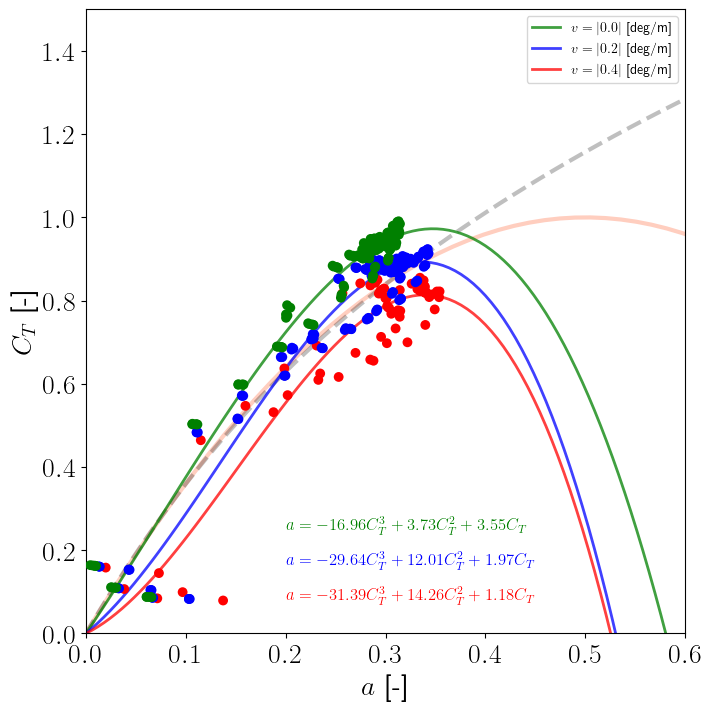

In [30]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

a_mom  = np.linspace(0,0.75,50)
ct_mom = 4 * a_mom * (1 - a_mom)
ax.plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1,alpha=0.25)

ct_mad = np.linspace(0,1.5,75)
k1 = 0.2460
k2 = 0.0586
k3 = 0.0883
a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
ax.plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2,alpha=0.25)

ax.plot(x_fit_v0, y_fit_v0, 'g-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.0|$ [deg/m]')
ax.plot(x_fit_v2, y_fit_v2, 'b-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.2|$ [deg/m]')
ax.plot(x_fit_v4, y_fit_v4, 'r-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.4|$ [deg/m]')

ax.set_xlim([0,0.6])
ax.set_ylim([0,1.5])

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

v4 = [0,12]
v2 = [1, 2, 3, 9, 10, 11]
v0 = [4, 5, 6, 7, 8]

for i in range(len(v4)):
    mesh = ax.scatter(ind_annular[:,v4[i]], ct_annular[:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3)

for i in range(len(v2)):
    mesh = ax.scatter(ind_annular[:,v2[i]], ct_annular[:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3)

for i in range(len(v0)):
    mesh = ax.scatter(ind_annular[:,v0[i]], ct_annular[:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3)

np.save("./annulus_coefficients/v0_15MW_rotor_averages.npy", [ind_annular,ct_annular])

ax.legend()

fig.text(0.4,0.25, f'$a = {a_fit_v0:0.2f}C_T^3 + {b_fit_v0:0.2f}C_T^2 + {c_fit_v0:0.2f}C_T$', ha='left', fontsize=12,rotation=0,color='green')
fig.text(0.4,0.20, f'$a = {a_fit_v2:0.2f}C_T^3 + {b_fit_v2:0.2f}C_T^2 + {c_fit_v2:0.2f}C_T$', ha='left', fontsize=12,rotation=0,color='blue')
fig.text(0.4,0.15, f'$a = {a_fit_v4:0.2f}C_T^3 + {b_fit_v4:0.2f}C_T^2 + {c_fit_v4:0.2f}C_T$', ha='left', fontsize=12,rotation=0,color='red')

plt.savefig(f"./figs/wrf_15MW_annulus.png", bbox_inches="tight", dpi=600)

/tmp/ipykernel_3755411/3928975633.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[0].scatter(ind_annular[:,v4[i]], ct_annular[:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.35)
/tmp/ipykernel_3755411/3928975633.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[1].scatter(ind_annular[:,v2[i]], ct_annular[:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.35)
/tmp/ipykernel_3755411/3928975633.py:38: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[2].scatter(ind_annular[:,v0[i]], ct_annular[:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.35)


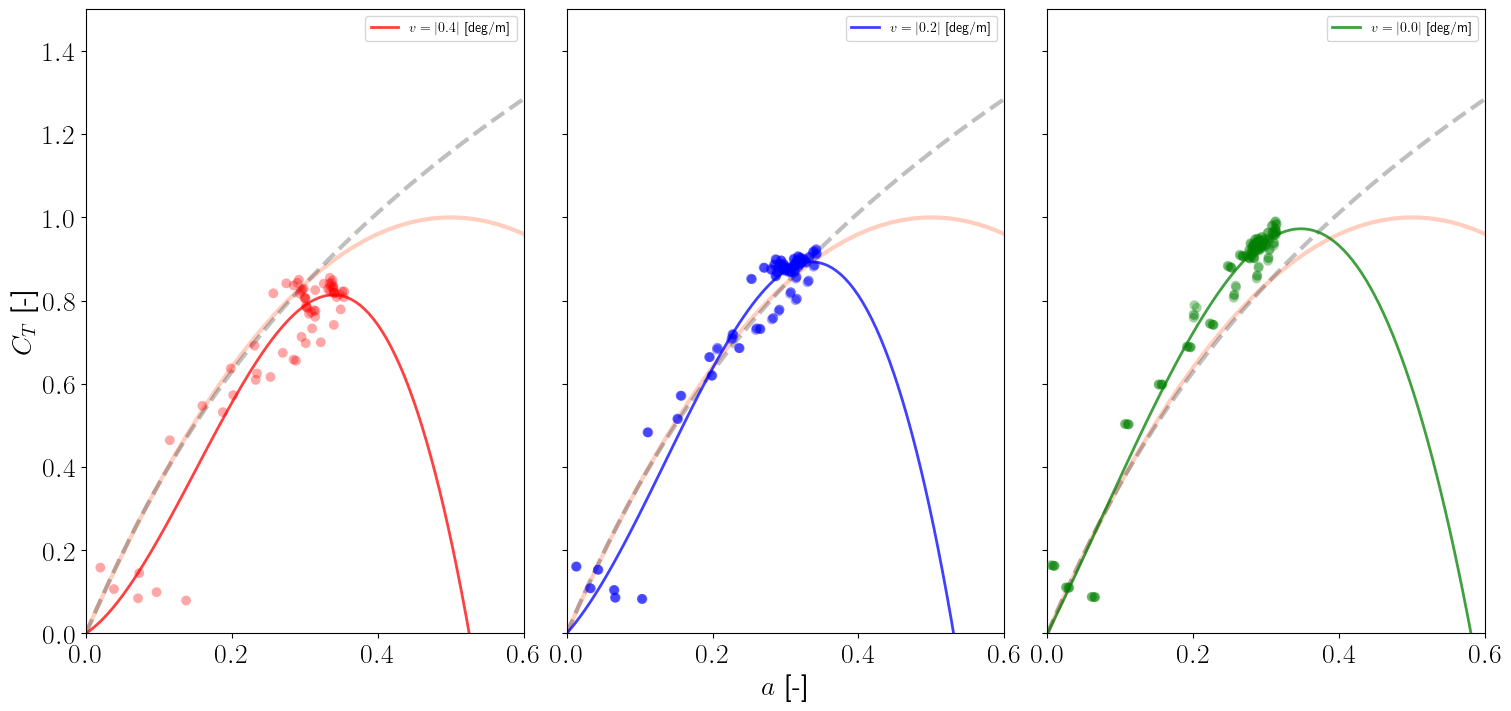

In [29]:
fig, ax = plt.subplots(1,3,figsize=(15, 7), constrained_layout=True,sharex=True, sharey=True)

a_mom  = np.linspace(0,0.75,50)
ct_mom = 4 * a_mom * (1 - a_mom)

ct_mad = np.linspace(0,1.5,75)
k1 = 0.2460
k2 = 0.0586
k3 = 0.0883
a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad

for i in range(3):
    ax[i].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1,alpha=0.25)

    ax[i].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2,alpha=0.25)

    ax[i].set_xlim([0,0.6])
    ax[i].set_ylim([0,1.5])

ax[0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[1].set_xlabel('$a$ [-]', fontsize=20)

ax[2].plot(x_fit_v0, y_fit_v0, 'g-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.0|$ [deg/m]')
ax[1].plot(x_fit_v2, y_fit_v2, 'b-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.2|$ [deg/m]')
ax[0].plot(x_fit_v4, y_fit_v4, 'r-',linewidth=2,zorder=2,alpha=0.75,label='$v = |0.4|$ [deg/m]')

v4 = [0,12]
v2 = [1, 2, 3, 9, 10, 11]
v0 = [4, 5, 6, 7, 8]

for i in range(len(v4)):
    mesh = ax[0].scatter(ind_annular[:,v4[i]], ct_annular[:,v4[i]], cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.35)

for i in range(len(v2)):
    mesh = ax[1].scatter(ind_annular[:,v2[i]], ct_annular[:,v2[i]], cmap='viridis', s=50, edgecolor='none',color='b',zorder=3,alpha=0.35)

for i in range(len(v0)):
    mesh = ax[2].scatter(ind_annular[:,v0[i]], ct_annular[:,v0[i]], cmap='viridis', s=50, edgecolor='none',color='g',zorder=3,alpha=0.35)

ax[0].legend()
ax[1].legend()
ax[2].legend()